# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle
# Import Module
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, run_scenario, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission
import libcbm

## Create and Run `ForestModel` instance

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

In [3]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [4]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

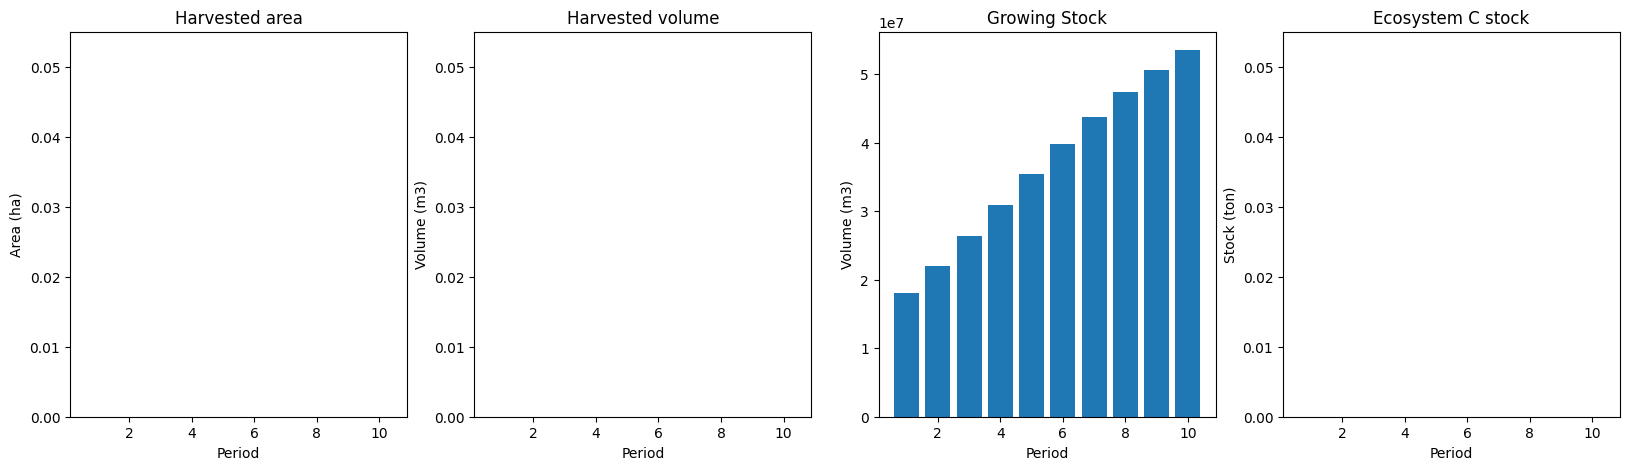

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [8]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [9]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [10]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]


npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

# decay_emissions_fluxes = [
#     'DecayVFastAGToAir',
#     'DecayVFastBGToAir',
#     'DecayFastAGToAir',
#     'DecayFastBGToAir',
#     'DecayMediumToAir',
#     'DecaySlowAGToAir',
#     'DecaySlowBGToAir',
#     'DecaySWStemSnagToAir',
#     'DecaySWBranchSnagToAir',
#     'DecayHWStemSnagToAir',
#     'DecayHWBranchSnagToAir'
# ]
ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']
GrossGrowth_pools = [
    'DeltaBiomass_AG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'DeltaBiomass_BG',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput']

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [11]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
# fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
# gross_growth = grossgrowth_ag + grossgrowth_bg
fluxes = ecosystem_decay_emissions_pools
gross_growth = GrossGrowth_pools
sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,1.403745e+07,3.874220e+07,5.277965e+07,0.000000e+00,0.000000e+00,0.000000
1,1.423830e+07,3.863534e+07,5.287364e+07,8.850461e+05,9.790345e+05,-93988.459640
2,1.443963e+07,3.854026e+07,5.297989e+07,8.807935e+05,9.870460e+05,-106252.503460
3,1.464088e+07,3.845560e+07,5.309648e+07,8.778403e+05,9.944342e+05,-116593.865791
4,1.484254e+07,3.838034e+07,5.322289e+07,8.758588e+05,1.002263e+06,-126404.196888
...,...,...,...,...,...,...
96,2.990867e+07,4.437639e+07,7.428506e+07,1.161644e+06,1.352158e+06,-190514.038495
97,2.999184e+07,4.448176e+07,7.447360e+07,1.164035e+06,1.352573e+06,-188538.465314
98,3.007064e+07,4.458672e+07,7.465736e+07,1.166360e+06,1.350117e+06,-183756.250185


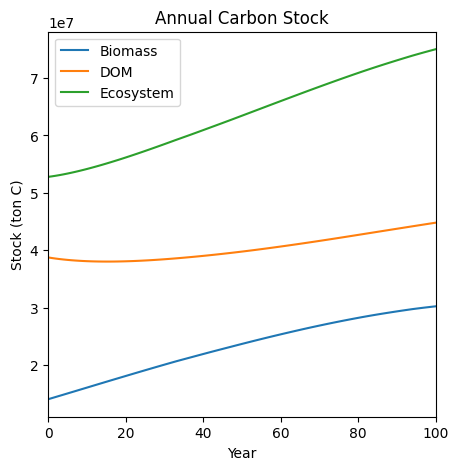

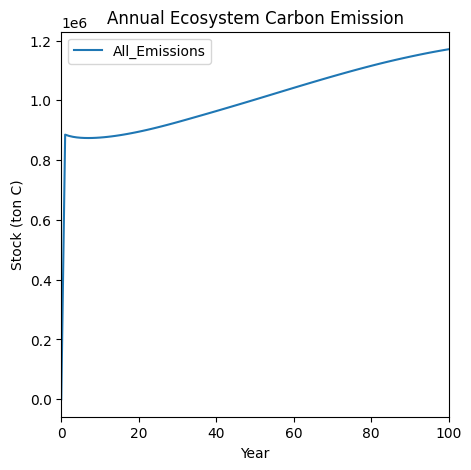

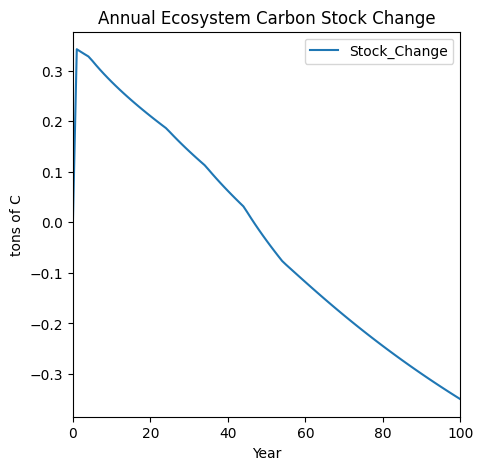

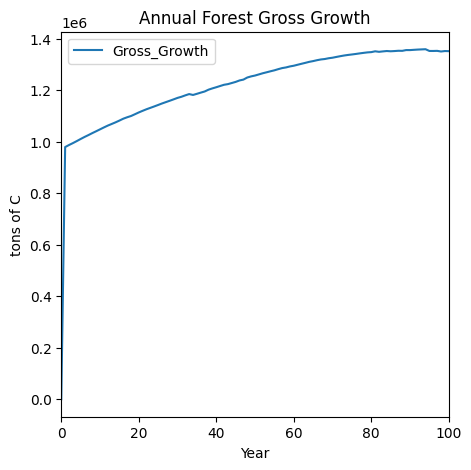

In [12]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Plug-in Carbon Yield Curves

In [13]:
# Read curves
c_curves_p = pd.read_pickle("./redchris_c_curves_p.pkl")
c_curves_f = pd.read_pickle("./redchris_c_curves_f.pkl")

In [14]:
# In order to reduce the impact of DOM input
# c_curves_p.loc[:59, 'DOM'] = c_curves_p.loc[:59, 'DOM'] * 0.1
# c_curves_p['ecosystem'] = c_curves_p['DOM'] + c_curves_p['biomass']

In [15]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, pools=sum_pools)
plugin_c_curves_both(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_emissions', 'total_emissions', 'gross_growth'])

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19', '19')
found match for mask ('?', '?', '?', '?', '20', '20')
found match for mask ('?', '?', '?', '?', '21', '21')
found match for mask ('?', '?', '?', '?', '22'

In [16]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7fe49ee47490>),
   ('ecosystem', <ws3.core.Curve at 0x7fe490d6fc40>),
   ('biomass', <ws3.core.Curve at 0x7fe490d6d210>),
   ('DOM', <ws3.core.Curve at 0x7fe490d88220>),
   ('net_emissions', <ws3.core.Curve at 0x7fe490d6f3a0>),
   ('total_emissions', <ws3.core.Curve at 0x7fe490d6fd00>),
   ('gross_growth', <ws3.core.Curve at 0x7fe490d880a0>),
   ('ecosystem', <ws3.core.Curve at 0x7fe490d6fc40>),
   ('biomass', <ws3.core.Curve at 0x7fe490d6d210>),
   ('DOM', <ws3.core.Curve at 0x7fe490d88220>),
   ('net_emissions', <ws3.core.Curve at 0x7fe490d6f3a0>),
   ('total_emissions', <ws3.core.Curve at 0x7fe490d6fd00>),
   ('gross_growth', <ws3.core.Curve at 0x7fe490d880a0>)]),
 (('?', '?', '?', '?', '1', '1'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7fe49ee47460>),
   ('ecosystem', <ws3.core.Curve at 0x7fe490d6dff0>),
   ('biomass', <ws3.core.Curve at 0x7fe490d6e110>),
   ('DOM'

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

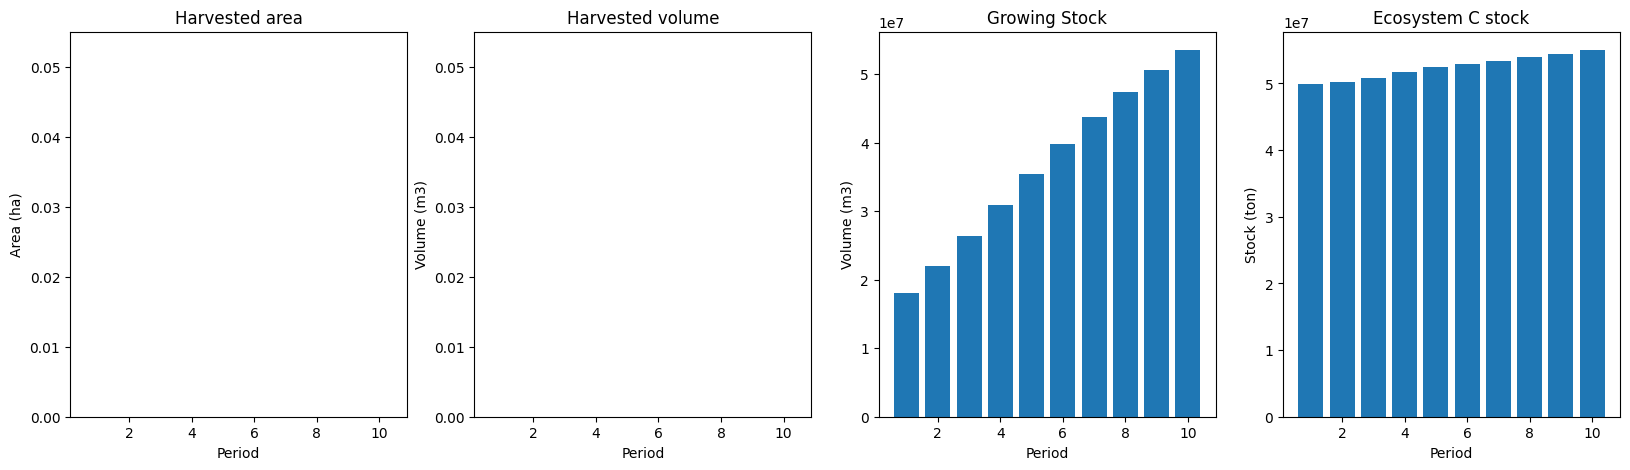

In [17]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## No-harvest

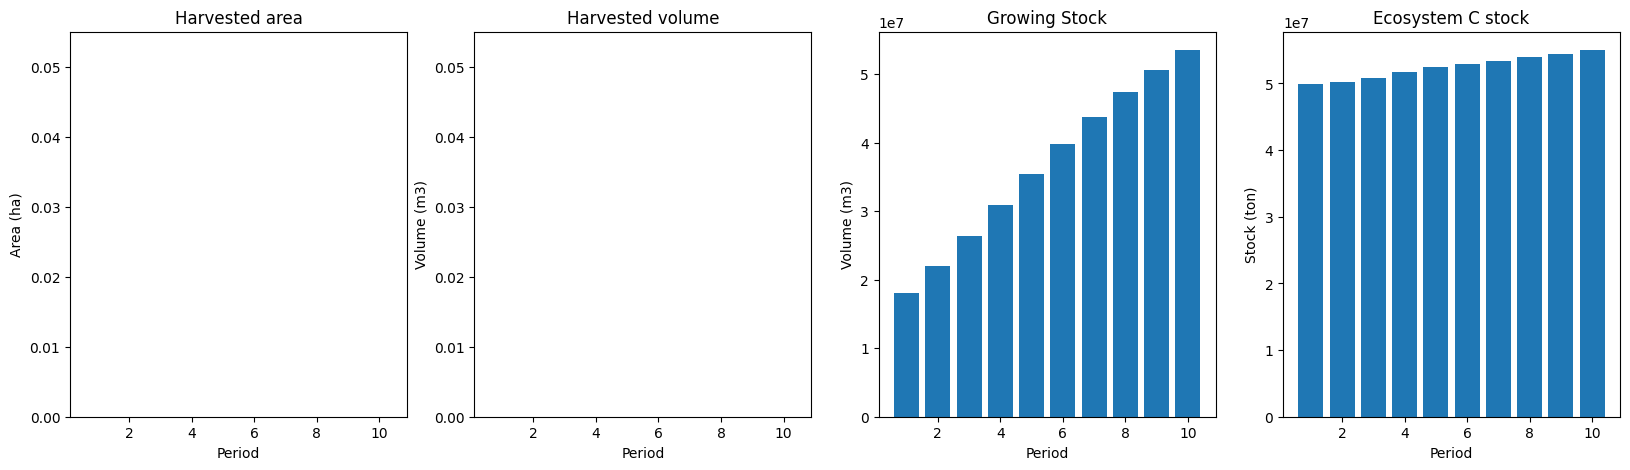

In [18]:
df = compile_scenario_maxstock(fm)
fig, ax = plot_scenario_maxstock(df)

In [19]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [20]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [21]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [22]:
sit_events

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [23]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change,Net_Emissions
Year,,,,,,,
0,1.403745e+07,3.874220e+07,5.277965e+07,0.000000e+00,0.000000e+00,0.000000,0.000000
1,1.423830e+07,3.863534e+07,5.287364e+07,3.245169e+06,-3.589793e+06,-93988.459640,-344624.352013
2,1.443963e+07,3.854026e+07,5.297989e+07,3.229576e+06,-3.619169e+06,-106252.503460,-389592.512685
3,1.464088e+07,3.845560e+07,5.309648e+07,3.218748e+06,-3.646259e+06,-116593.865791,-427510.841233
4,1.484254e+07,3.838034e+07,5.322289e+07,3.211482e+06,-3.674964e+06,-126404.196888,-463482.055254
...,...,...,...,...,...,...,...
96,2.990867e+07,4.437639e+07,7.428506e+07,4.259360e+06,-4.957911e+06,-190514.038495,-698551.474483
97,2.999184e+07,4.448176e+07,7.447360e+07,4.268127e+06,-4.959435e+06,-188538.465314,-691307.706150
98,3.007064e+07,4.458672e+07,7.465736e+07,4.276654e+06,-4.950427e+06,-183756.250185,-673772.917346


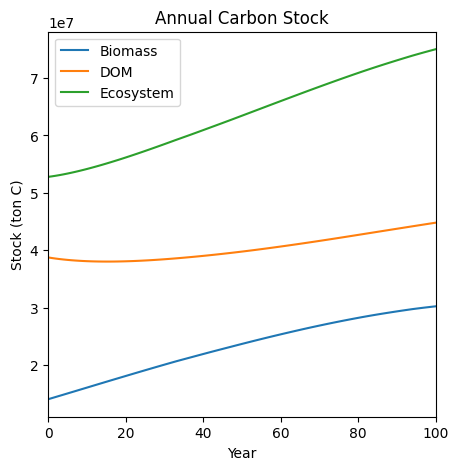

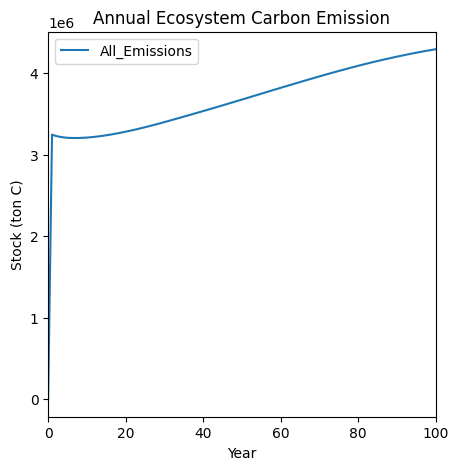

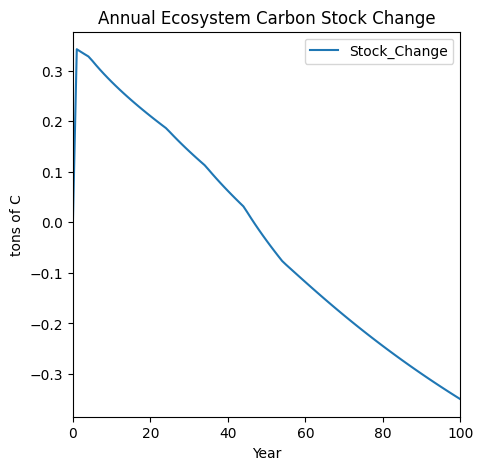

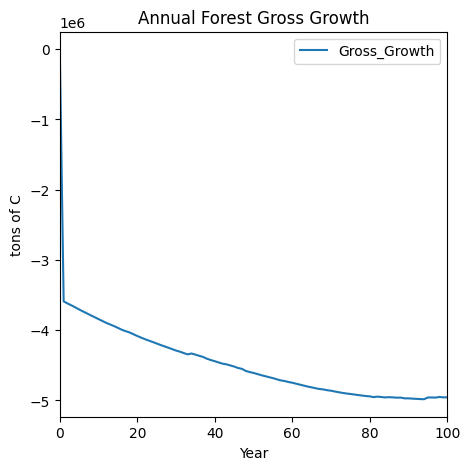

In [24]:
# Report Annual CBM Outputs
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)
cbm_report_both(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

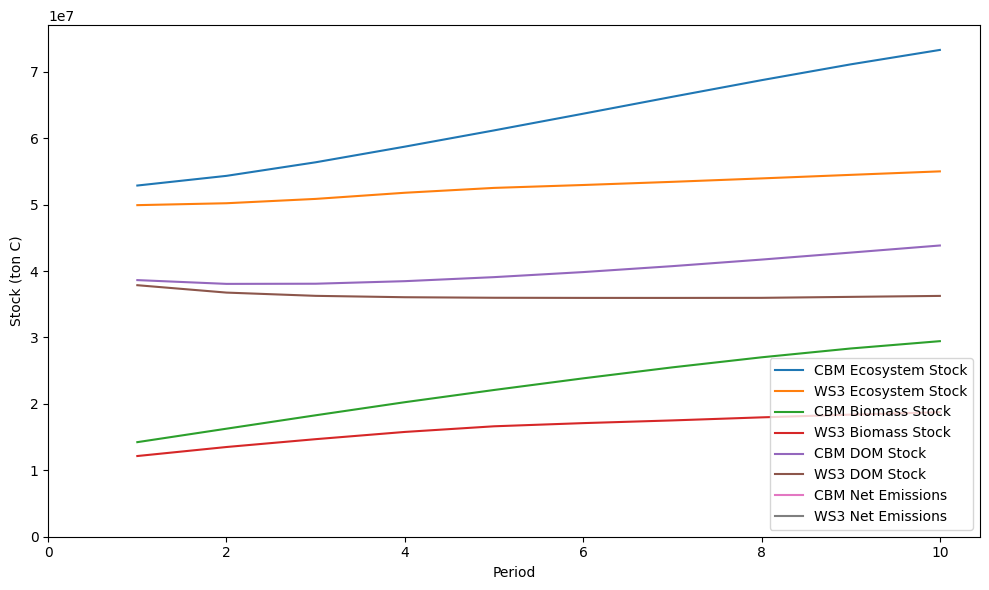

(   period  biomass_stock     dom_stock     eco_stock  \
 0       1   1.423830e+07  3.863534e+07  5.287364e+07   
 1       2   1.626471e+07  3.806644e+07  5.433115e+07   
 2       3   1.828427e+07  3.809009e+07  5.637435e+07   
 3       4   2.025381e+07  3.847495e+07  5.872876e+07   
 4       5   2.209131e+07  3.908150e+07  6.117281e+07   
 5       6   2.384425e+07  3.984339e+07  6.368764e+07   
 6       7   2.549859e+07  4.073631e+07  6.623491e+07   
 7       8   2.701085e+07  4.172410e+07  6.873496e+07   
 8       9   2.834004e+07  4.277782e+07  7.111786e+07   
 9      10   2.944286e+07  4.384605e+07  7.328891e+07   
 
    ecosystem_decay_emissions  gross_growth  net_emissions  eco_stock_change  
 0               3.245169e+06 -3.589793e+06 -344624.352013      0.000000e+00  
 1               3.213583e+06 -3.869338e+06 -655755.824444      1.457514e+06  
 2               3.291613e+06 -4.106028e+06 -814415.485726      2.043203e+06  
 3               3.412292e+06 -4.305830e+06 -893537.878

In [25]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='whole')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="whole")

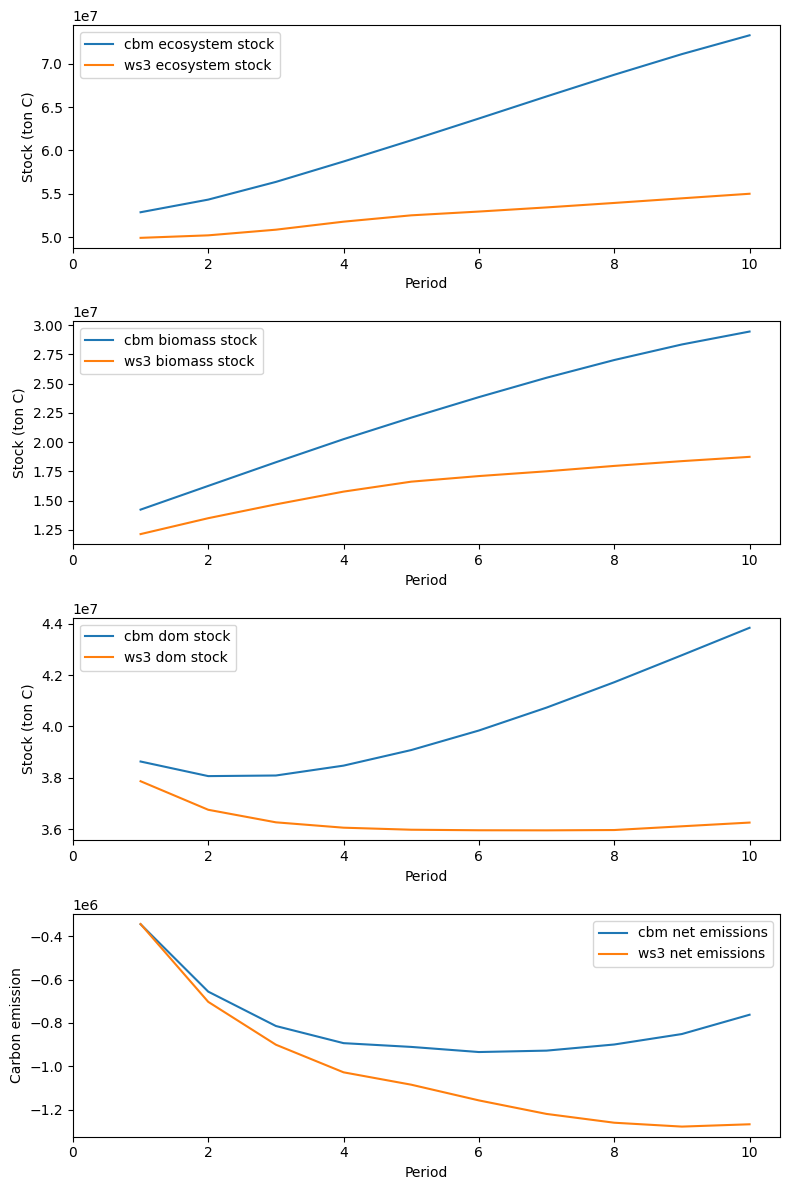

(   period  biomass_stock     dom_stock     eco_stock  \
 0       1   1.423830e+07  3.863534e+07  5.287364e+07   
 1       2   1.626471e+07  3.806644e+07  5.433115e+07   
 2       3   1.828427e+07  3.809009e+07  5.637435e+07   
 3       4   2.025381e+07  3.847495e+07  5.872876e+07   
 4       5   2.209131e+07  3.908150e+07  6.117281e+07   
 5       6   2.384425e+07  3.984339e+07  6.368764e+07   
 6       7   2.549859e+07  4.073631e+07  6.623491e+07   
 7       8   2.701085e+07  4.172410e+07  6.873496e+07   
 8       9   2.834004e+07  4.277782e+07  7.111786e+07   
 9      10   2.944286e+07  4.384605e+07  7.328891e+07   
 
    ecosystem_decay_emissions  gross_growth  net_emissions  eco_stock_change  
 0               3.245169e+06 -3.589793e+06 -344624.352013      0.000000e+00  
 1               3.213583e+06 -3.869338e+06 -655755.824444      1.457514e+06  
 2               3.291613e+06 -4.106028e+06 -814415.485726      2.043203e+06  
 3               3.412292e+06 -4.305830e+06 -893537.878

In [26]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='individual')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="individual")

## Maximize the Total System Carbon Stock and Minimze Net Carbon Emission

In [27]:
def select_obj(obj_mode):
    print(f"Selected scenario: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_em',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Objective:', index=3, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_em')

In [28]:
obj_mode = obj_dropdown.value

In [29]:
from util_opt import cmp_c_ss, cmp_c_se

running no constraints scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3667 rows, 34533 columns and 34533 nonzeros
Model fingerprint: 0x97b55ac3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3667 rows and 34533 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0246197e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective -1.024619655e+07


[]

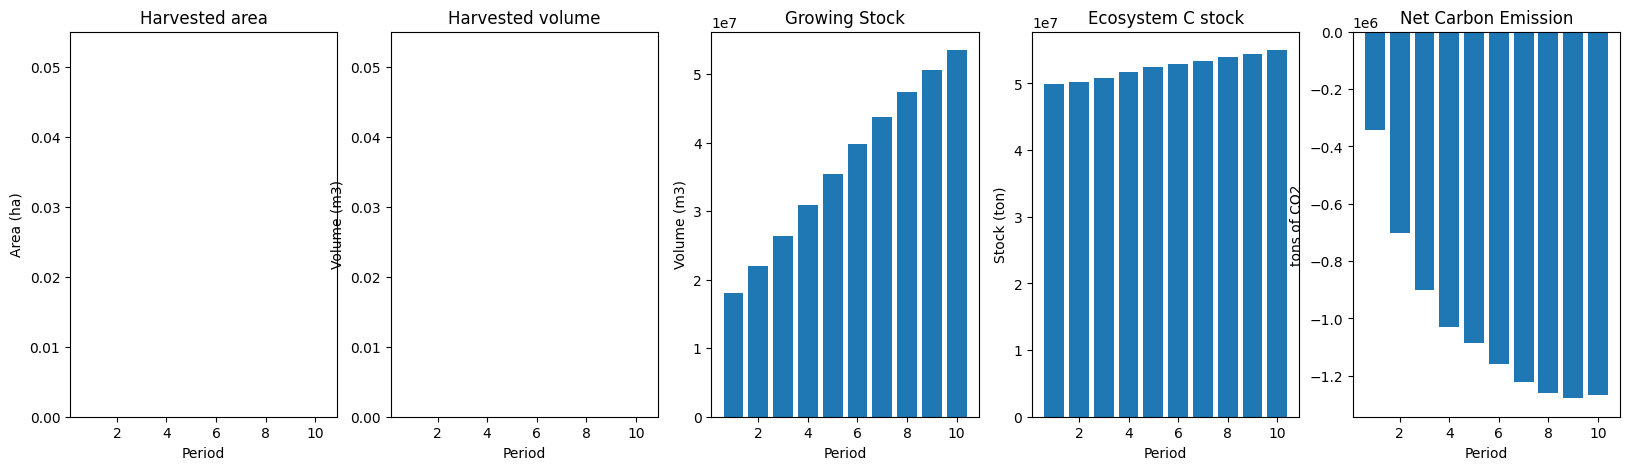

In [30]:
# Maximize Harvest
run_scenario(fm, obj_mode , 'no_cons')

In [31]:
# fm.applied_actions

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
    period  solid_wood  paper  sum_product     ecosystem        system
 0       1         0.0    0.0          0.0  4.991964e+07  4.991964e+07
 1       2         0.0    0.0          0.0  5.020821e+07  5.020821e+07
 2       3         0.0    0.0          0.0  5.086052e+07  5.086052e+07
 3       4         0.0    0.0          0.0  5.178568e+07  5.178568e+07
 4       5         0.0    0.0          0.0  5.251682e+07  5.251682e+07
 5       6         

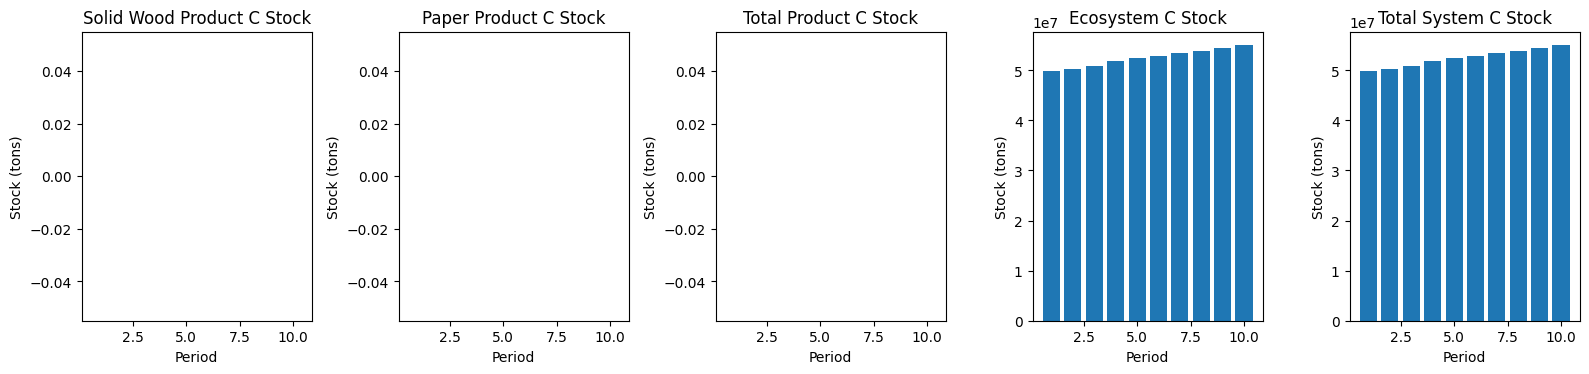

In [32]:
track_system_stock(fm)

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
    period  solid_wood  paper  sum_product     ecosystem        system
 0       1         0.0    0.0          0.0  0.000000e+00  0.000000e+00
 1       2         0.0    0.0          0.0 -1.058067e+06 -1.058067e+06
 2       3         0.0    0.0          0.0 -2.391792e+06 -2.391792e+06
 3       4         0.0    0.0          0.0 -3.392265e+06 -3.392265e+06
 4       5         0.0    0.0          0.0 -2.6808

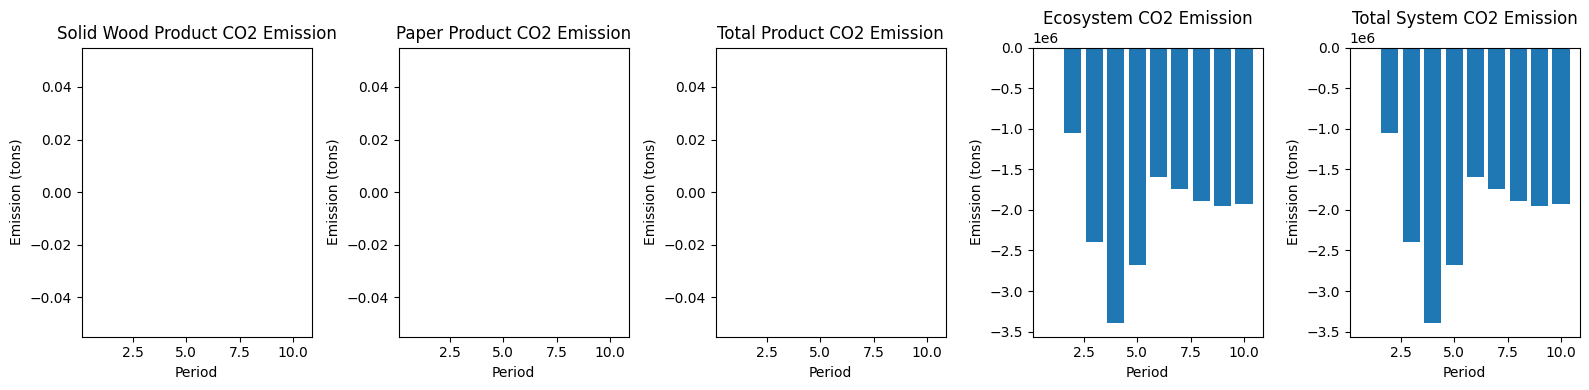

In [33]:
track_system_emission(fm)